In [ ]:
pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od

In [ ]:
dataset='https://www.kaggle.com/datasets/kumaresanmanickavelu/lyft-udacity-challenge'

In [ ]:
od.download(dataset)

Skipping, found downloaded files in "./lyft-udacity-challenge" (use force=True to force download)


In [ ]:
import os

In [ ]:
data_dir='./lyft-udacity-challenge'

In [ ]:
os.listdir(data_dir)

['dataB',
 'dataA',
 'datae',
 'datac',
 'datad',
 'dataa',
 'dataC',
 'dataE',
 'dataD',
 'datab']

In [ ]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio

import matplotlib.pyplot as plt
%matplotlib inline

path = '/content/lyft-udacity-challenge/dataA/dataA'
image_path = os.path.join(path, 'CameraRGB/')
mask_path = os.path.join(path, 'CameraSeg/')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

In [ ]:
len(image_list)

1000

Text(0.5, 1.0, 'Segmentation')

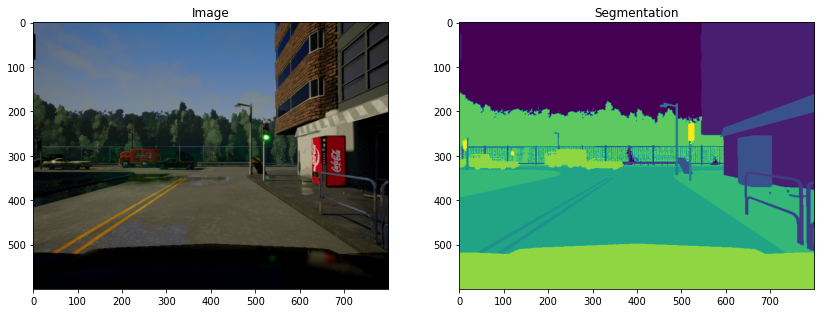

In [ ]:
N = 3
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

 Split Your Dataset into Unmasked and Masked Images

In [ ]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/lyft-udacity-challenge/dataA/dataA/CameraRGB/02_00_000.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/lyft-udacity-challenge/dataA/dataA/CameraSeg/02_00_000.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/lyft-udacity-challenge/dataA/dataA/CameraRGB/02_00_001.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/lyft-udacity-challenge/dataA/dataA/CameraSeg/02_00_001.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/lyft-udacity-challenge/dataA/dataA/CameraRGB/02_00_010.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/lyft-udacity-challenge/dataA/dataA/CameraSeg/02_00_010.png'>)


In [ ]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'/content/lyft-udacity-challenge/dataA/dataA/CameraRGB/08_00_101.png', shape=(), dtype=string)
tf.Tensor(b'/content/lyft-udacity-challenge/dataA/dataA/CameraSeg/08_00_101.png', shape=(), dtype=string)


Preprocess Your Data

In [ ]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (256, 256), method='nearest')
    input_mask = tf.image.resize(mask, (256, 256), method='nearest')

    input_image = input_image / 512

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)



In [ ]:
from keras.models import Sequential
from itertools import permutations
import tensorflow.compat.v2 as tf
from tensorflow.compat.v2.keras.layers import Permute
from skimage import morphology
import numpy as np
import cv2
import glob
import itertools
import numpy as np
from keras.models import Sequential,Model
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Cropping2D
from keras.layers import Input, Add, Dropout, Permute, add, Activation
from keras.layers.convolutional import Conv2DTranspose
from scipy.io import loadmat
import tensorflow as tf
import numpy as np
from keras.optimizers import Adam, RMSprop
from keras.metrics import categorical_crossentropy,binary_crossentropy
from threading import Thread
import time
from keras import backend as K
import numpy as np
from keras.models import Sequential,Model
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Cropping2D, Conv2DTranspose, UpSampling2D
from keras.layers import Input, Add, Dropout, Permute, add, concatenate, Reshape, Activation, BatchNormalization
from scipy.io import loadmat
from keras.layers import PReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D, ZeroPadding2D
from keras.layers.core import SpatialDropout2D, Permute, Activation, Reshape
from keras.layers import add, concatenate
from tensorflow.keras.layers import BatchNormalization
from keras.layers.pooling import MaxPooling2D
#from keras.engine.topology import Input
from keras.utils.layer_utils import get_source_inputs
from keras.models import Model
#from crfrnn_layer import CrfRnnLayer

from tensorflow.keras.utils import  load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import *
from keras.layers import *

In [ ]:
# The following code has been taken from [1]
class MeanIoU(object):
 #   """Mean intersection over union (mIoU) metric.
 #   Intersection over union (IoU) is a common evaluation metric for semantic
 #   segmentation. The predictions are first accumulated in a confusion matrix
 #   and the IoU is computed from it as follows:
  #      IoU = true_positive / (true_positive + false_positive + false_negative).
  #  The mean IoU is the mean of IoU between all classes.
  #  Keyword arguments:
   #     num_classes (int): number of classes in the classification problem.
   # """

    def __init__(self, num_classes):
        super().__init__()

        self.num_classes = num_classes

    def mean_iou(self, y_true, y_pred):
   #     """The metric function to be passed to the model.
      #  Args:
       #     y_true (tensor): True labels.
      #      y_pred (tensor): Predictions of the same shape as y_true.
     #   Returns:
     #       The mean intersection over union as a tensor.
    #    """
        # Wraps _mean_iou function and uses it as a TensorFlow op.
        # Takes numpy arrays as its arguments and returns numpy arrays as
        # its outputs.
        return tf.py_function(self._mean_iou, [y_true, y_pred], tf.float32)

    def _mean_iou(self, y_true, y_pred):
  #      """Computes the mean intesection over union using numpy.
   #     Args:
   #         y_true (tensor): True labels.
   #         y_pred (tensor): Predictions of the same shape as y_true.
   #     Returns:
   #         The mean intersection over union (np.float32).
   #     """
        # Compute the confusion matrix to get the number of true positives,
        # false positives, and false negatives
        # Convert predictions and target from categorical to integer format
        target = np.argmax(y_true, axis=-1).ravel()
        predicted = np.argmax(y_pred, axis=-1).ravel()

        # Trick for bincounting 2 arrays together
        x = predicted + self.num_classes * target
        bincount_2d = np.bincount(
            x.astype(np.int32), minlength=self.num_classes**2
        )
        assert bincount_2d.size == self.num_classes**2
        conf = bincount_2d.reshape(
            (self.num_classes, self.num_classes)
        )

        # Compute the IoU and mean IoU from the confusion matrix
        true_positive = np.diag(conf)
        false_positive = np.sum(conf, 0) - true_positive
        false_negative = np.sum(conf, 1) - true_positive

        # Just in case we get a division by 0, ignore/hide the error and
        # set the value to 1 since we predicted 0 pixels for that class and
        # and the batch has 0 pixels for that same class
        with np.errstate(divide='ignore', invalid='ignore'):
            iou = true_positive / (true_positive + false_positive + false_negative)
        iou[np.isnan(iou)] = 1

        return np.mean(iou).astype(np.float32)

ENet Model
ENet (efficient neural network) has been specifically created for tasks requiring low latency operations. It is claimed to be 18 times faster and having 79 times less parameters than other image segmentation architectures, while providing similar or better accuracy.

In [ ]:
#Encoder
def downsample_bottleneck(o, output_size , asymmetric=0, dilated=0, downsample=0):

    second_branch = o
    input_n_channels = o.get_shape().as_list()[3]
    padding = output_size - input_n_channels

    # reducing the channels (1x1)
    if downsample:
        stride = 2
    else:
        stride =1

    o = Conv2D(output_size//4, (stride, stride),strides=(stride, stride), use_bias=False)(o)
    o = BatchNormalization(momentum=0.1)(o)
    o = PReLU(shared_axes=[1, 2])(o)

    # Perfroming convolution (COnv)
    if asymmetric:
        o = Conv2D(output_size//4, (1, asymmetric), padding='same', use_bias=False)(o)
        o = Conv2D(output_size//4, (asymmetric, 1), padding='same')(o)
    else:
        if dilated:
            o = Conv2D(output_size//4, (3, 3), dilation_rate=(dilated, dilated), padding='same')(o)
        else:
            o = Conv2D(output_size//4, (3, 3), padding='same')(o)

    o = BatchNormalization(momentum=0.1)(o)
    o = PReLU(shared_axes=[1, 2])(o)

    # Producing back the channels (1x1)
    o = Conv2D(output_size, (1, 1), use_bias=False)(o)
    o = BatchNormalization(momentum=0.1)(o)

    # Performing regularization (Regularizer)
    o = SpatialDropout2D(0.1)(o)

    # Second branch

    #performing max pooling only if downsample
    if downsample:
        second_branch = MaxPooling2D()(second_branch)

        #performing padding -- only required if downsampling
        second_branch = Permute((1, 3, 2))(second_branch)
        second_branch = ZeroPadding2D(padding=((0, 0), (0, padding)))(second_branch)
        second_branch = Permute((1, 3, 2))(second_branch)

    o = add([o, second_branch])
    o = PReLU(shared_axes=[1, 2])(o)

    return o


In [ ]:
# decoder
def upsample_bottleneck(o, output_size, upsample=0):

    other_branch = o

    o = Conv2D(output_size//4, (1, 1), use_bias=False)(o)
    o = BatchNormalization(momentum=0.1)(o)
    o = Activation('relu')(o)

    #Applyting transpose convolution if upsampling
    if upsample:
        o = Conv2DTranspose(output_size//4, kernel_size=(3, 3), strides=(2, 2), padding='same')(o)
    else:
        o = Conv2D(output_size//4, (3, 3), padding='same', use_bias=True)(o)

    o = BatchNormalization(momentum=0.1)(o)
    o = Activation('relu')(o)

    o = Conv2D(output_size, (1, 1), padding='same', use_bias=False)(o)

    # upsampling the other branch as well
    if upsample:
            other_branch = Conv2D(output_size, (1, 1), padding='same', use_bias=False)(other_branch)
            other_branch = BatchNormalization(momentum=0.1)(other_branch)
            other_branch = UpSampling2D(size=(2, 2))(other_branch)


    o = BatchNormalization(momentum=0.1)(o)
    o = add([o, other_branch])
    o = Activation('relu')(o)

    return o


In [ ]:
 #Defining the model
def ENet(n_classes, input_height, input_width):

    img_input = Input(shape=(input_height, input_width, 3))


    ## Section Initial
    conv = Conv2D(13, (3, 3), padding='same', strides=(2,2))(img_input)
    max_pool = MaxPooling2D()(img_input)
    merged = concatenate([conv, max_pool], axis=3)
    o = BatchNormalization(momentum=0.1)(merged)
    o = PReLU(shared_axes=[1, 2])(o)
    ### Section Initial End

    ##Section 2 and 3
    o = downsample_bottleneck(o, 64, downsample=True) # 1.1

    for _ in range(4): #1.2-1.5
        o = downsample_bottleneck(o, 64)

    o = downsample_bottleneck(o, 128, downsample=True) #2.0

    for _ in range(2):
        o = downsample_bottleneck(o, 128)  # 2.1
        o = downsample_bottleneck(o, 128, dilated=2)  # 2.2
        o = downsample_bottleneck(o, 128, asymmetric=5)  #2.3
        o = downsample_bottleneck(o, 128, dilated=4)  # 2.4
        o = downsample_bottleneck(o, 128)  # 2.5
        o = downsample_bottleneck(o, 128, dilated=8)  # 2.6
        o = downsample_bottleneck(o, 128, asymmetric=5)  # 2.7
        o = downsample_bottleneck(o, 128, dilated=16)  # 2.8

    ## Section 2 and 3 end


    ## Section 4
    o = upsample_bottleneck(o, 64, upsample=True)  # 4.0
    o = upsample_bottleneck(o, 64)  # 4.1
    o = upsample_bottleneck(o, 64)  # 4.2
    # Section 4 ends

    #Section 5
    o = upsample_bottleneck(o, 16, upsample=True)  # bottleneck 5.0
    o = upsample_bottleneck(o, 16)  # bottleneck 5.1
    #section 5 ends

    o = Conv2DTranspose(filters=n_classes, kernel_size=(2, 2), strides=(2, 2), padding='same')(o)

    o = Activation('softmax')(o)
    model = Model(img_input, o)

    return model

In [ ]:
#Compiling the model
model2 = ENet(1, 256, 256)

miou_metric = MeanIoU(13)
model2.compile(optimizer=Adam(lr=.001), loss= 'categorical_crossentropy', metrics = ['accuracy', miou_metric.mean_iou])

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:

model2.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_86 (Conv2D)             (None, 128, 128, 13  364         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 128, 128, 3)  0          ['input_2[0][0]']                
                                                                                            

In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = model2.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None))
Epoch 1/20
32/32 [==============================] - 79s 520ms/step - loss: 0.0000e+00 - accuracy: 0.0847 - mean_iou: 1.0000
Epoch 2/20
32/32 [==============================] - 10s 319ms/step - loss: 0.0000e+00 - accuracy: 0.0847 - mean_iou: 1.0000
Epoch 3/20
32/32 [==============================] - 10s 319ms/step - loss: 0.0000e+00 - accuracy: 0.0847 - mean_iou: 1.0000
Epoch 4/20
32/32 [==============================] - 10s 325ms/step - loss: 0.0000e+00 - accuracy: 0.0847 - mean_iou: 1.0000
Epoch 5/20
32/32 [==============================] - 10s 323ms/step - loss: 0.0000e+00 - accuracy: 0.0847 - mean_iou: 1.0000
Epoch 6/20
32/32 [==============================] - 10s 320ms/step - loss: 0.0000e+00 - accuracy: 0.0847 - mean_iou: 1.0000
Epoch 7/20
32/32 [==============================] - 10s 324ms/step - loss: 0.0000e+00 - accuracy: 0.0847 - mean_iou: 1.0000
Epoch 8/2